# Section 1: Extracting training and testing dataset

In [61]:
import pandas as pd 
train_df=pd.read_csv('C:\\workspace\\Credit-Risk-Modeling\\dataset\\loan_data_2007_2014\\train_df.csv',index_col=0)
test_df=pd.read_csv('C:\\workspace\\Credit-Risk-Modeling\\dataset\\loan_data_2007_2014\\test_df.csv',index_col=0)

In [62]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.216667,0.216667,0.227857,0.524225,0.190530,0.002267,0.480847,0.830958,0.000000,0.030303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.681159,0.681159,0.685714,0.463663,0.585368,0.011736,0.027218,0.535884,0.000000,0.030303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.420290,0.420290,0.428571,0.120155,0.325384,0.007306,0.722782,0.299075,0.034483,0.030303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.000000,1.000000,1.000000,0.683140,0.647125,0.026407,0.110887,0.249312,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.333333,0.333333,0.342143,0.431686,0.284289,0.008402,0.325605,0.665916,0.000000,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [63]:
X_train=train_df.iloc[:,:-1]
y_train=train_df.iloc[:,-1]

X_test=test_df.iloc[:,:-1]
y_test=test_df.iloc[:,-1]

In [64]:
X_train.shape,X_test.shape

((326399, 92), (139886, 92))

In [65]:
y_train.shape,y_test.shape

((326399,), (139886,))

In [66]:
import numpy as np
train_np=np.concatenate((np.array(X_train),np.array(y_train).reshape((-1,1))),axis=1)

# Section 2: Hyperparametertuning

In [67]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_score,recall_score,precision_recall_curve,roc_curve,confusion_matrix
from sklearn.utils import resample

from xgboost import XGBClassifier

In [68]:
def make_balance(fit_df):
    fit_df_1=fit_df[fit_df[:,-1]==0]
    fit_df_0=fit_df[fit_df[:,-1]==1]
    max_count=np.floor(len(fit_df_0)/len(fit_df_1))
    residuals=int(len(fit_df_0)-max_count*len(fit_df_1))
    balance_count=1
    fit_df2=np.array(pd.DataFrame(fit_df_1).copy())
    while balance_count<max_count:
        fit_df2=np.concatenate((fit_df2,fit_df_1))
        balance_count=balance_count+1
    fit_df2=np.concatenate((fit_df2,resample(fit_df_1,replace=False,n_samples=residuals)))
    fit_df2=np.concatenate((fit_df2,fit_df_0))
    fit_df2=resample(fit_df2,replace=False,n_samples=len(fit_df2))
    return fit_df2

In [69]:
def ensemble_xgb(train_np,params,test_size=0.3):
    n_estimators=params['n_estimators']
    object=params['objective']
    tree_method=params['tree_method']
    depth_list=params['max_depth']
    eta_list=params['eta']
    model_dic={}
    model_number=1
    
    fit_df,val_df=train_test_split(train_np,random_state=None,test_size=test_size,stratify=train_np[:,-1])
    
    fit_df2=make_balance(fit_df) 
    X_fit=fit_df2[:,:-1]
    y_fit=fit_df2[:,-1]

    val_df2=make_balance(val_df) 
    X_val=val_df2[:,:-1]
    y_val=val_df2[:,-1]

    for i in depth_list:
        for j in eta_list:
            for k in n_estimators:
                model=XGBClassifier(n_estimators=np.round(k),objective=object,tree_method=tree_method,early_stopping_rounds=50,
                                    learning_rate=j,max_depth=i,n_jobs=-1,eval_metric=['auc']).fit(X_fit,y_fit,eval_set=[(X_val,y_val)])
                #f_1_accuracy_score=f1_score(y_val,pred)
                model_dic['model_number_{}'.format(model_number)]=\
                    {'n_estimators':model.best_iteration,'max_depth':i,'learning_rate':j,'accuracy_score':model.best_score}
                print(model_dic['model_number_{}'.format(model_number)])
                model_number=model_number+1


    model_df=pd.DataFrame(model_dic)
    
    return model_df

In [70]:
#param1={'n_estimators':[2000],'max_depth':[3,5,8,12,15],'eta':[0.1,0.05,0.01],'objective':'binary:logistic','tree_method':'hist'}
param1={'n_estimators':[20000],'max_depth':[3],'eta':[0.1],'objective':'binary:logistic','tree_method':'hist'}
len(param1['n_estimators'])*len(param1['max_depth'])*len(param1['eta'])

1

In [71]:
selected_model1=ensemble_xgb(train_np,param1)

[0]	validation_0-auc:0.89749
[1]	validation_0-auc:0.92847
[2]	validation_0-auc:0.93974
[3]	validation_0-auc:0.93994
[4]	validation_0-auc:0.93995
[5]	validation_0-auc:0.94387
[6]	validation_0-auc:0.94270
[7]	validation_0-auc:0.94444
[8]	validation_0-auc:0.94569
[9]	validation_0-auc:0.94483
[10]	validation_0-auc:0.94901
[11]	validation_0-auc:0.94781
[12]	validation_0-auc:0.95115
[13]	validation_0-auc:0.95393
[14]	validation_0-auc:0.95821
[15]	validation_0-auc:0.96022
[16]	validation_0-auc:0.96125
[17]	validation_0-auc:0.96491
[18]	validation_0-auc:0.96584
[19]	validation_0-auc:0.96683
[20]	validation_0-auc:0.96701
[21]	validation_0-auc:0.96887
[22]	validation_0-auc:0.96909
[23]	validation_0-auc:0.96940
[24]	validation_0-auc:0.97167
[25]	validation_0-auc:0.97249
[26]	validation_0-auc:0.97339
[27]	validation_0-auc:0.97343
[28]	validation_0-auc:0.97484
[29]	validation_0-auc:0.97624
[30]	validation_0-auc:0.97683
[31]	validation_0-auc:0.97741
[32]	validation_0-auc:0.97855
[33]	validation_0-au

In [76]:
selected_model1

,model_number_1
accuracy_score,0.991771
learning_rate,0.100000
max_depth,3.000000
n_estimators,1330.000000


In [77]:
train_np2=make_balance(train_np)

In [78]:
pd.Series(train_np2[:,-1]).value_counts()

0.0    290721
1.0    290721
Name: count, dtype: int64

In [79]:
X_train2=train_np2[:,:-1]
y_train2=train_np2[:,-1]

In [80]:
model=XGBClassifier(n_estimators=1330,max_depth=3,learning_rate=0.1,n_jobs=-1,objective='binary:logistic').fit(X_train2,y_train2)
pred=model.predict(X_test)
est_prob=model.predict_proba(X_test)

In [89]:
roc_auc_score(y_test,pred)

0.951044077663718

In [90]:
recall_score(y_test,pred)

0.9721339368840091

In [91]:
precision_score(y_test,pred)

0.9912353205941323

In [92]:
f1_score(y_test,pred)

0.9815917112050278

In [93]:
accuracy_score(y_test,pred)

0.9675235548947

In [94]:
confusion_matrix(y_test,pred)

array([[ 14219,   1071],
       [  3472, 121124]], dtype=int64)

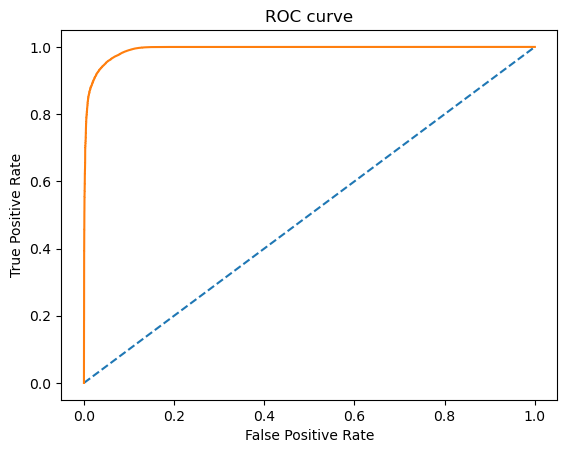

In [95]:
import matplotlib.pyplot as plt
fpr=roc_curve(y_test,est_prob[:,1])[0]
tpr=roc_curve(y_test,est_prob[:,1])[1]
#plt.figure(figsize=(20,8))
plt.plot(fpr,fpr,'--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

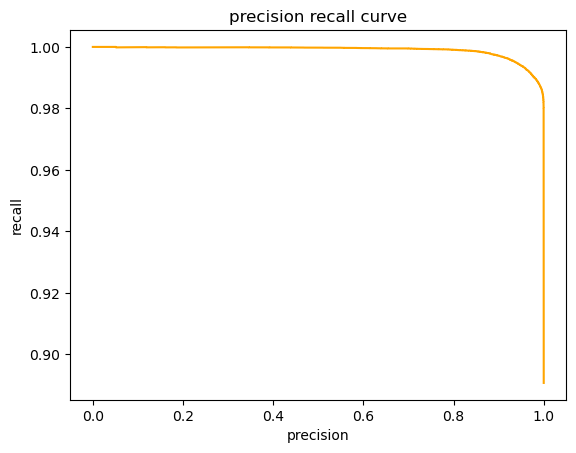

In [96]:
recall_axis=precision_recall_curve(y_test,est_prob[:,1])[0]
precision_axis=precision_recall_curve(y_test,est_prob[:,1])[1]
plt.plot(precision_axis,recall_axis,c='orange')

plt.xlabel('precision')
plt.ylabel('recall')
plt.title('precision recall curve')
plt.show()